In [1]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pygmmis
from sklearn.cluster import KMeans
import json
import pickle
import matplotlib.gridspec as gridspec

In [2]:
vphi_data = 'df_v_final.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [3]:
df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_R_uncertainty", "v_phi_uncertainty", "v_Z", "v_Z_uncertainty"])

In [4]:
import pandas as pd
from tqdm import tqdm

def filter_metallicity_bin(df, min_mh, max_mh):
    """
    Filter the dataframe to get stars in the specified metallicity range.
    Args:
    - df: The dataframe containing the data.
    - min_mh: The minimum metallicity value.
    - max_mh: The maximum metallicity value.
    
    Returns:
    - df_bin: The filtered dataframe containing only the stars in the metallicity range.
    """
    df_bin = df[(df['mh_xgboost'] >= min_mh) & (df['mh_xgboost'] < max_mh)]
    return df_bin

df_vmp = filter_metallicity_bin(df_v,-3,-2)
df_imp = filter_metallicity_bin(df_v,-2,-1.6)
df_mp1 = filter_metallicity_bin(df_v,-1.6,-1.3)
df_mp2 = filter_metallicity_bin(df_v,-1.3,-1)

In [5]:
df_vmp.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,...,R_gal,phi_gal,Z_gal,v_phi,v_R,v_Z,rpgeo_error,v_R_uncertainty,v_phi_uncertainty,v_Z_uncertainty
423,5154922827885952,170.657245,-47.285226,43.071608,4.076372,0.379446,0.018582,19.793915,0.019437,-13.200543,...,1847.736334,0.161813,-1980.563197,-28.672386,228.320454,-141.733613,131.27490,3.273386,14.402553,1.480388
1426,15542185269834624,168.864959,-39.383137,47.301290,10.900462,0.427245,0.018026,-8.020415,0.020875,-18.292858,...,1770.129000,0.192972,-1437.698310,152.431999,-183.267474,-100.993822,90.86035,4.492863,2.996476,6.190263
1975,23128987300185088,161.113675,-46.079151,38.591744,9.022822,0.444738,0.014322,21.460042,0.017848,-24.744448,...,1584.923568,0.326941,-1628.267978,-98.174807,36.122335,-62.336769,81.13782,1.641303,12.150945,2.709389
1978,23153245275421056,160.116715,-46.808666,37.604696,8.792205,0.457407,0.014301,19.199156,0.017124,-19.458318,...,1508.139330,0.344088,-1589.093041,-25.620412,62.095080,-58.999607,62.40881,1.072166,7.872995,1.232714
2604,29649366130846592,166.103287,-38.041565,46.481259,13.308729,0.582180,0.015261,55.151524,0.018218,-44.976356,...,1370.678841,0.240542,-1059.753273,-328.322431,99.860631,15.821360,48.50122,3.482296,17.934260,0.497230


In [6]:
with open("gmm_vmp.pkl", "rb") as f:
    gmm_vmp = pickle.load(f)

with open("gmm_imp.pkl", "rb") as f:
    gmm_imp = pickle.load(f)

with open("gmm_mp1.pkl", "rb") as f:
    gmm_mp1 = pickle.load(f)

with open("gmm_mp2.pkl", "rb") as f:
    gmm_mp2 = pickle.load(f)

In [7]:
def generate_mock_stars(gmm, num_samples):
    """
    Generates mock stars from a fitted GMM, ensuring that it returns all three velocity components (v_R, v_phi, v_Z).
    
    Args:
    - gmm: The fitted Gaussian Mixture Model.
    - num_samples: Number of mock stars to generate.
    
    Returns:
    - mock_data: Array of shape (num_samples, 3) containing (v_R, v_phi, v_Z).
    """
    mock_data = gmm.draw(num_samples)  # Ensure this returns at least 3 columns
    if mock_data.shape[1] < 3:
        raise ValueError(f"generate_mock_stars returned shape {mock_data.shape}, expected at least 3 columns (v_R, v_phi, v_Z).")

    return mock_data[:, :3]  # Extract v_R, v_phi, v_Z


def compute_residuals(df_bin, gmm, bins=100, x_limits=(-400, 400), y_limits=(-400, 400)):
    """Computes normalised residuals between the observed data and mock GMM data."""
    df_filtered = df_bin.dropna(subset=["v_R", "v_phi"])
    
    # Generate mock stars from GMM
    mock_stars = generate_mock_stars(gmm, len(df_filtered))
    
    # Compute 2D histograms
    H_obs, xedges, yedges = np.histogram2d(df_filtered["v_R"], df_filtered["v_phi"], bins=bins, range=[x_limits, y_limits])
    H_mock, _, _ = np.histogram2d(mock_stars[:, 0], mock_stars[:, 1], bins=bins, range=[x_limits, y_limits])

    # Compute normalised residual
    H_residual = (H_obs - H_mock) / (H_obs + H_mock + 1e-5)  # Avoid division by zero

    return H_residual, xedges, yedges

/var/folders/p3/pkt6pdhs7fq9ksxkhmbp2_xr0000gn/T/ipykernel_59953/175156080.py:29: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(right=0.85)  # Leave space for the colorbar



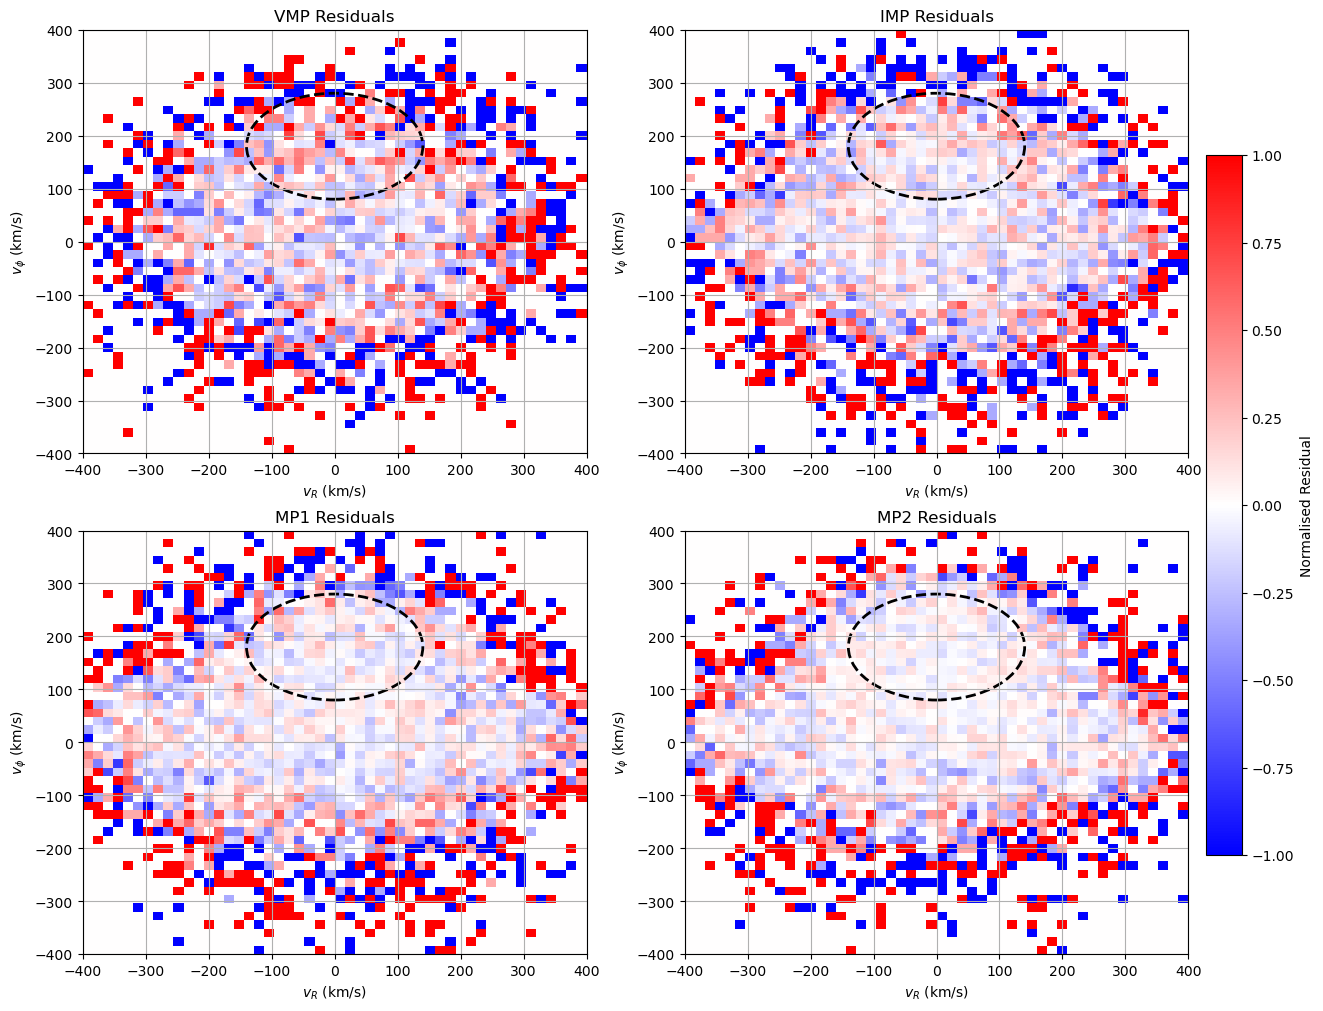

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_residuals(df_vmp, df_imp, df_mp1, df_mp2, gmm_vmp, gmm_imp, gmm_mp1, gmm_mp2, bins=50):
    """
    Plots normalised residuals for VMP, IMP, MP1, and MP2 bins with an **external** colorbar.
    
    Args:
    - df_vmp, df_imp, df_mp1, df_mp2: DataFrames for the VMP, IMP, MP1, and MP2 bins.
    - gmm_vmp, gmm_imp, gmm_mp1, gmm_mp2: Corresponding fitted GMMs.
    - bins: Number of bins for histograms.
    """
    fig, ax = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

    # Compute residuals
    H_residual_vmp, xedges_vmp, yedges_vmp = compute_residuals(df_vmp, gmm_vmp, bins)
    H_residual_imp, xedges_imp, yedges_imp = compute_residuals(df_imp, gmm_imp, bins)
    H_residual_mp1, xedges_mp1, yedges_mp1 = compute_residuals(df_mp1, gmm_mp1, bins)
    H_residual_mp2, xedges_mp2, yedges_mp2 = compute_residuals(df_mp2, gmm_mp2, bins)

    # Define thick disc kinematics region (Grey Ellipse) using 2σ values
    disc_ellipse_params = {
        "xy": (0, 180),  # Mean position (v_R, v_phi) = (0, 180) km/s
        "width": 2 * 70 * 2,  # 2σ_R = 2 * 70 km/s
        "height": 2 * 50 * 2,  # 2σ_phi = 2 * 50 km/s
    }

    # Create a **single colorbar axis** for all subplots
    fig.subplots_adjust(right=0.85)  # Leave space for the colorbar
    cbar_ax = fig.add_axes([1.00, 0.15, 0.03, 0.7])  # [left, bottom, width, height]

    # Plot residuals with the **shared colorbar**
    vmin, vmax = -1, 1  # Color range for normalised residuals
    for H_residual, xedges, yedges, title, ax_i in zip(
        [H_residual_vmp, H_residual_imp, H_residual_mp1, H_residual_mp2],
        [xedges_vmp, xedges_imp, xedges_mp1, xedges_mp2],
        [yedges_vmp, yedges_imp, yedges_mp1, yedges_mp2],
        ["VMP Residuals", "IMP Residuals", "MP1 Residuals", "MP2 Residuals"],
        ax.flatten()
    ):
        im = ax_i.pcolormesh(xedges, yedges, H_residual.T, cmap="bwr", shading="auto", vmin=vmin, vmax=vmax)
        ax_i.set_xlabel(r"$v_R$ (km/s)")
        ax_i.set_ylabel(r"$v_\phi$ (km/s)")
        ax_i.set_title(title)
        ax_i.grid(True)

        # Add thick disc kinematics ellipse
        disc_ellipse = Ellipse(**disc_ellipse_params, edgecolor="black", facecolor="none", linewidth=2, linestyle="dashed")
        ax_i.add_patch(disc_ellipse)

    # Add a **single colorbar** to the right
    cbar = fig.colorbar(im, cax=cbar_ax, label="Normalised Residual")

    plt.show()

# Example usage
plot_residuals(df_vmp, df_imp, df_mp1, df_mp2, gmm_vmp, gmm_imp, gmm_mp1, gmm_mp2, bins=50)


In [9]:
import numpy as np

def generate_mock_stars(gmm, num_samples):
    """
    Generates mock stars from a fitted GMM, ensuring that it returns all three velocity components (v_R, v_phi, v_Z).
    
    Args:
    - gmm: The fitted Gaussian Mixture Model.
    - num_samples: Number of mock stars to generate.
    
    Returns:
    - mock_data: Array of shape (num_samples, 3) containing (v_R, v_phi, v_Z).
    """
    mock_data = gmm.draw(num_samples)  # Ensure this returns at least 3 columns
    if mock_data.shape[1] < 3:
        raise ValueError(f"generate_mock_stars returned shape {mock_data.shape}, expected at least 3 columns (v_R, v_phi, v_Z).")

    return mock_data[:, :3]  # Extract v_R, v_phi, v_Z


def compute_residuals_monte_carlo(df_bin, gmm, bins=100, x_limits=(-400, 400), y_limits=(-400, 400), num_samples=200, ellipse_params=None):
    """
    Computes normalised residuals between the observed data and mock GMM data
    using Monte Carlo sampling with 200 iterations, counting only the stars within the given ellipse.
    
    Args:
    - df_bin: DataFrame containing observed velocities (v_R, v_phi).
    - gmm: The fitted Gaussian Mixture Model.
    - bins: Number of bins for the histogram.
    - x_limits: Limits for v_R histogram.
    - y_limits: Limits for v_phi histogram.
    - num_samples: Number of Monte Carlo samples (default: 200).
    - ellipse_params: Dictionary containing the ellipse parameters (xy, width, height).
    
    Returns:
    - mean_H_residual: Mean residuals within the ellipse over 200 Monte Carlo iterations.
    - std_H_residual: Standard deviation of residuals within the ellipse over 200 iterations.
    """
    if ellipse_params is None:
        raise ValueError("Ellipse parameters must be provided.")

    df_filtered = df_bin.dropna(subset=["v_R", "v_phi"])
    num_stars = len(df_filtered)
    
    # Compute observed histogram
    H_obs, xedges, yedges = np.histogram2d(df_filtered["v_R"], df_filtered["v_phi"], bins=bins, range=[x_limits, y_limits])
    
    # Compute bin centers
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers, indexing='ij')
    
    # Define the ellipse filter
    x_cent, y_cent = ellipse_params["xy"]
    width, height = ellipse_params["width"], ellipse_params["height"]
    norm_x = ((X - x_cent) / (width / 2)) ** 2
    norm_y = ((Y - y_cent) / (height / 2)) ** 2
    inside_ellipse = (norm_x + norm_y) <= 1
    
    residuals_list = []
    
    for _ in range(num_samples):
        # Generate mock stars
        mock_stars = generate_mock_stars(gmm, num_stars)
        
        # Compute histogram of mock data
        H_mock, _, _ = np.histogram2d(mock_stars[:, 0], mock_stars[:, 1], bins=bins, range=[x_limits, y_limits])
        
        # Compute normalised residual
        H_residual = (H_obs - H_mock) / (H_obs + H_mock + 1e-5)  # Avoid division by zero
        
        # Only count residuals inside the ellipse
        residuals_list.append(H_residual[inside_ellipse].flatten())  # Flatten to avoid shape issues
    
    # Convert to numpy array and compute mean and standard deviation
    residuals_array = np.concatenate(residuals_list)  # Flatten across iterations
    mean_H_residual = np.mean(residuals_array)
    std_H_residual = np.std(residuals_array)
    
    return mean_H_residual, std_H_residual


In [17]:
ellipse_params = {
    "xy": (0, 180),  # Mean position (v_R, v_phi) = (0, 180) km/s
    "width": 2 * 70 * 2,  # 2σ_R = 2 * 70 km/s
    "height": 2 * 50 * 2,  # 2σ_phi = 2 * 50 km/s
}

mean_residual, std_residual = compute_residuals_monte_carlo(df_vmp, gmm_vmp, bins=100, ellipse_params=ellipse_params)
print(f"Mean Residual vmp: {mean_residual}, Standard Deviation vmp: {std_residual}")
mean_residual, std_residual = compute_residuals_monte_carlo(df_imp, gmm_imp, bins=100, ellipse_params=ellipse_params)
print(f"Mean Residual imp: {mean_residual}, Standard Deviation imp: {std_residual}")


Mean Residual vmp: 0.02622876267236361, Standard Deviation vmp: 0.634485900813441
Mean Residual imp: 0.031335349621231655, Standard Deviation imp: 0.4701776000134353


In [97]:
import numpy as np

def compute_disc_residuals_multiple_runs(df_bin, gmm, bins=50, n_repeats=200):
    """
    Computes the mean residual count inside the thick disc region over multiple mock samples.

    Args:
    - df_bin: DataFrame of stars for a metallicity bin.
    - gmm: Corresponding fitted GMM.
    - bins: Number of bins for histogram calculations.
    - n_repeats: Number of times to repeat mock sample generation.

    Returns:
    - mean_count: Mean normalized residual count inside the thick disc.
    - std_count: Standard deviation (uncertainty) of residual count.
    """
    residual_counts = []

    for _ in range(n_repeats):
        # Compute residuals
        H_residual, xedges, yedges = compute_residuals(df_bin, gmm, bins)

        # Count residuals inside thick disc ellipse
        count, sum_residuals, std_count, _ = count_residuals_within_ellipse(
            H_residual, xedges, yedges, {
                "xy": (0, 180),
                "width": 2 * 70 * 2,
                "height": 2 * 50 * 2
            }
        )
        # Append **normalized residuals** instead of just raw counts
        residual_counts.append(sum_residuals)

    # Compute mean and standard deviation of residual counts
    mean_count = np.mean(residual_counts)
    std_count = np.std(residual_counts)

    return mean_count, std_count

# Compute disc residuals for VMP and IMP bins with 200 mock samples
mean_residual_vmp, std_residual_vmp = compute_disc_residuals_multiple_runs(df_vmp, gmm_vmp, bins=50, n_repeats=200)
mean_residual_imp, std_residual_imp = compute_disc_residuals_multiple_runs(df_imp, gmm_imp, bins=50, n_repeats=200)

# Print final results
print(f"VMP: Residual count = {mean_residual_vmp:.2f} ± {std_residual_vmp:.2f}")
print(f"IMP: Residual count = {mean_residual_imp:.2f} ± {std_residual_imp:.2f}")


VMP: Residual count = 7.69 ± 3.91
IMP: Residual count = 5.55 ± 1.97
